In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# going to the repository of this note book
%cd drive/My Drive/Thesis/CPNN_PiggyBack/CSS
!ls

/content/drive/My Drive/Thesis/CPNN_PiggyBack/CSS
datasets  models  performance  run_test  Untitled0.ipynb


In [3]:
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
import argparse
from torch.autograd import Variable
import pprint
import copy

In [18]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import math


def mask_init(module):
    scores = torch.Tensor(module.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores

def mask_initv2(module):
    scores = torch.Tensor(module.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores[0]

def rank_one_init(module):
    scores = torch.Tensor(module.size(0))
    nn.init.uniform_(scores, a=-1, b=1)
    scores = scores.sign().float()
    return scores

def rank_one_initv2(module):
    scores = torch.Tensor(module.size(1))
    nn.init.uniform_(scores, a=-1, b=1)
    scores = scores.sign().float()
    return scores


def pspinit(module):
    scores = torch.Tensor(module.size())
    nn.init.kaiming_uniform_(scores, a=math.sqrt(5))
    return scores

def bn_mask_init(module):
    return torch.ones(module.num_features)


def bn_mask_initv2(module):
    return torch.zeros(module.num_features)


class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None


class GetSignedSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        ctx.save_for_backward(scores)
        out = scores.clone()
        _, idx = scores.abs().flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out * scores.sign()

    @staticmethod
    def backward(ctx, g):
        scores, = ctx.saved_tensors

        # send the gradient g straight-through on the backward pass.
        return g , None


def get_subnet(scores, k):
    out = scores.clone()
    _, idx = scores.flatten().sort()
    j = int((1 - k) * scores.numel())

    # flat_out and out access the same memory.
    flat_out = out.flatten()
    flat_out[idx[:j]] = 0
    flat_out[idx[j:]] = 1

    return out

def get_subnet_signed(scores, k):
    out = scores.clone()
    _, idx = scores.abs().flatten().sort()
    j = int((1 - k) * scores.numel())

    # flat_out and out access the same memory.
    flat_out = out.flatten()
    flat_out[idx[:j]] = 0
    flat_out[idx[j:]] = 1

    return out * scores.sign()


class GetSubnetFast(autograd.Function):
    @staticmethod
    def forward(ctx, scores, a=0):
        return (scores >= a).float()

    @staticmethod
    def backward(ctx, g):
        return g, None


def get_subnet_fast(scores, a=0):
    return (scores >= a).float()


def kaiming_normal(module):
    scores = torch.Tensor(module.weight.size())
    nn.init.kaiming_normal_(scores, nonlinearity="relu")
    return scores

In [19]:
#from models.parser import * as _parser
from models.parser import *
import argparse
import sys
import yaml

args = None


def parse_arguments():
    # Training settings
    parser = argparse.ArgumentParser(description="SupSup")
    parser.add_argument(
        "--config", type=str, default=None, help="Config file to use, YAML format"
    )
    parser.add_argument(
        "--optimizer", type=str, default="sgd", help="Which optimizer to use"
    )
    parser.add_argument(
        "--batch-size",
        type=int,
        default=128,
        metavar="N",
        help="input batch size for training (default: 64)",
    )
    parser.add_argument(
        "--test-batch-size",
        type=int,
        default=128,
        metavar="N",
        help="input batch size for testing (default: 128)",
    )
    parser.add_argument(
        "--epochs",
        type=int,
        default=100,
        metavar="N",
        help="number of epochs to train (default: 100)",
    )
    parser.add_argument(
        "--lr",
        type=float,
        default=0.1,
        metavar="LR",
        help="learning rate (default: 0.1)",
    )
    parser.add_argument(
        "--momentum",
        type=float,
        default=0.9,
        metavar="M",
        help="Momentum (default: 0.9)",
    )
    parser.add_argument(
        "--wd",
        type=float,
        default=0.0001,
        metavar="M",
        help="Weight decay (default: 0.0001)",
    )

    parser.add_argument(
        "--seed", type=int, default=1, metavar="S", help="random seed (default: 1)"
    )
    parser.add_argument(
        "--log-interval",
        type=int,
        default=10,
        metavar="N",
        help="how many batches to wait before logging training status",
    )
    parser.add_argument("--workers", type=int, default=4, help="how many cpu workers")
    parser.add_argument(
        "--output-size",
        type=int,
        default=10,
        help="how many total neurons in last layer",
    )
    parser.add_argument(
        "--real-neurons", type=int, default=10, help="how many real neurons"
    )
    parser.add_argument("--name", type=str, default="default", help="Experiment id.")
    parser.add_argument(
        "--data", type=str, help="Location to store data",
    )
    parser.add_argument(
        "--log-dir",
        type=str,
        help="Location to logs/checkpoints",
    )
    parser.add_argument("--resume", type=str, default=None, help='optionally resume')
    parser.add_argument(
        "--sparsity", type=float, default=0.5, help="how sparse is each layer, when using MultitaskMaskConv"
    )
    parser.add_argument("--gamma", type=float, default=0.0)
    parser.add_argument(
        "--width-mult", type=float, default=1.0, help="how wide is each layer"
    )
    parser.add_argument(
        "--hop-weight", type=float, default=1e-3, help="how wide is each layer"
    )
    parser.add_argument(
        "--conv_type", type=str, default="StandardConv", help="Type of conv layer"
    )
    parser.add_argument(
        "--bn_type", type=str, default="StandardBN", help="Type of batch norm layer."
    )
    parser.add_argument(
        "--conv-init",
        type=str,
        default="default",
        help="How to initialize the conv weights.",
    )
    parser.add_argument("--model", type=str, help="Type of model.")
    parser.add_argument(
        "--multigpu",
        default=None,
        type=lambda x: [int(a) for a in x.split(",")],
        help="Which GPUs to use for multigpu training",
    )
    parser.add_argument(
        "--eval-ckpts",
        default=None,
        type=lambda x: [int(a) for a in x.split(",")],
        help="After learning n tasks for n in eval_ckpts we perform evaluation on all tasks learned so far",
    )
    parser.add_argument("--mode", default="fan_in", help="Weight initialization mode")
    parser.add_argument(
        "--nonlinearity", default="relu", help="Nonlinearity used by initialization"
    )

    parser.add_argument(
        "--num-tasks",
        default=None,
        type=int,
        help="Number of tasks, None if no adaptation is necessary",
    )
    parser.add_argument(
        "--adaptor",
        default="gt",
        help="Which adaptor to use, see adaptors.py",
    )
    parser.add_argument("--set", type=str, help="Which dataset to use")
    parser.add_argument("--er-sparsity", action="store_true", default=False)
    parser.add_argument(
        "--trainer",
        default=None,
        type=str,
        help="Which trainer to use, default in trainers/default.py",
    )
    parser.add_argument(
        "--log-base",
        default=2,
        type=int,
        help="keep the bottom 1/log_base elements during binary optimization",
    )
    parser.add_argument(
        "--save", action="store_true", default=False, help="save checkpoints"
    )
    parser.add_argument(
        "--train-weight-tasks",
        type=int,
        default=0,
        metavar="N",
        help="number of tasks to train the weights, e.g. 1 for batchensembles. -1 for all tasks",
    )
    parser.add_argument(
        "--train-weight-lr",
        default=0.1,
        type=float,
        help="While training the weights, which LR to use.",
    )

    parser.add_argument(
        "--individual-heads",
        action="store_true",
        help="Seperate head for each batch_ensembles task!",
    )
    parser.add_argument("--no-scheduler", action="store_true", help="constant LR")

    parser.add_argument(
        "--iter-lim", default=-1, type=int,
    )

    parser.add_argument(
        "--ortho-group", action="store_true", default=False,
    )

    # TODO: task-eval move out to diff main
    parser.add_argument("--lr-policy", default=None, help="Scheduler to use")
    parser.add_argument(
        "--task-eval",
        default=None,
        type=int,
        help="Only evaluate on this task (for memory efficiency and grounded task info",
    )
    parser.add_argument(
        "-f",
        "--dummy",
        default=None,
        help="Dummy to use for ipython notebook compatibility",
    )

    parser.add_argument(
        "--warmup-length", default=0, type=int,
    )
    parser.add_argument(
        "--reinit-most-recent-k",
        default=None,
        type=int,
        help="Whether or not to include a memory buffer for reinit training. Currently only works with binary reinit_adaptor",
    )
    parser.add_argument(
        "--reinit-adapt",
        type=str,
        default="binary",
        help="Adaptor for reinitialization experiments",
    )

    parser.add_argument(
        "--data-to-repeat", default=1, type=int,
    )

    parser.add_argument(
        "--unshared_labels", action="store_true", default=False,
    )

    args = parser.parse_args()

    # Allow for use from notebook without config file
    if args.config is not None:
        get_config(args)

    return args


def get_config(args):
    # get commands from command line
    override_args = _parser.argv_to_vars(sys.argv)

    # load yaml file
    yaml_txt = open(args.config).read()

    # override args
    loaded_yaml = yaml.load(yaml_txt, Loader=yaml.FullLoader)
    for v in override_args:
        loaded_yaml[v] = getattr(args, v)

    print(f"=> Reading YAML config from {args.config}")
    args.__dict__.update(loaded_yaml)


def run_args():
    global args
    if args is None:
        args = parse_arguments()


run_args()

In [20]:
import math
import torch
import torch.nn as nn

#from models.args import args


def signed_constant(module):
    fan = nn.init._calculate_correct_fan(module, args.mode)
    gain = nn.init.calculate_gain(args.nonlinearity)
    std = gain / math.sqrt(fan)
    module.data = module.data.sign() * std
    return module.data

def unsigned_constant(module):
    fan = nn.init._calculate_correct_fan(module, args.mode)
    gain = nn.init.calculate_gain(args.nonlinearity)
    std = gain / math.sqrt(fan)
    module.data = torch.ones_like(module.data) * std
    return module.data

def kaiming_normal(module):
    module.data = nn.init.kaiming_normal_(
        module, mode=args.mode, nonlinearity=args.nonlinearity
      )
    return module.data

def kaiming_uniform(module):
    module.data = nn.init.kaiming_uniform_(
        module, mode=args.mode, nonlinearity=args.nonlinearity
    )
    return module.data

def xavier_normal(module):
    module.data = kaiming_uniform = nn.init.xavier_normal_(
        module
    )
    return module.data

def glorot_uniform(module):
    module.data = nn.init.xavier_uniform_(
        module
    )
    return module.data

def xavier_constant(module):
    fan = nn.init._calculate_correct_fan(module, args.mode)
    gain = 1.0
    std = gain / math.sqrt(fan)
    module.data = module.data.sign() * std
    return module.data

def default(module):
    module.data = nn.init.kaiming_uniform_(module, a=math.sqrt(5))
    return module.data

In [21]:
# this is related to the random_model file
import torch
from torch import nn
import numpy as np
from collections import OrderedDict

class GRU_Model(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        weights_init_fn=default,
        many_to_one=False,
        remember_states = None,

    ):
        super(GRU_Model, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.remember_states = remember_states
        self.weights_init_fn = weights_init_fn

        self.h0 = np.zeros((1, self.hidden_size))
        self.many_to_one = many_to_one

        #self.gru = self.gru.to(device)
        #self.linear = self.linear.to(device)
        self.classifier = nn.Sequential(OrderedDict([
            ('GRU1', nn.GRU(input_size, hidden_size, num_layers, batch_first=True)),
            ('Linear1', nn.Linear(hidden_size, output_size))]
        ))
        self.all_weights=self.classifier.state_dict()
        self.weights_keys = self.all_weights.keys()
        for key in self.weights_keys:
          # 5 is like a treshold we define for considering weights that the length are more than 5
          if (self.all_weights[key].dim() == 1) & ((self.all_weights[key].shape)[0]>5):
            num_rows = 1
            num_columns = -1
            self.all_weights[key]= self.weights_init_fn(self.all_weights[key].view(num_rows, num_columns))[0]
          elif self.all_weights[key].dim() > 1:
            self.all_weights[key]= self.weights_init_fn(self.all_weights[key])

        self.classifier.load_state_dict(self.all_weights)
'''
    def forward(self, x, train=False):
        input_f = x.to(self.device)

        out_h, _ = self.gru(input_f,self._build_initial_state(x, self.h0))
        if self.many_to_one:
            out = self.linear(out_h[:,-1:,:])
        else:
            out = self.linear(out_h)

        if train and self.remember_states:
            self.h0 = out_h[:, 1, :].detach().numpy()
        return out

    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

'''
class LSTM_Model(nn.Module):
    def __init__(
        self,
        input_size=2,
      	num_layers=1,
        device=torch.device("cpu"),
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None
    ):
        super(LSTM_Model, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.num_layers = num_layers
        self.h0 = np.zeros((1, self.hidden_size))
        self.c0 = np.zeros((1, self.hidden_size))
        self.many_to_one = many_to_one

        # LAYERS
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        self.lstm.to(self.device)
        self.linear = nn.Linear(hidden_size, output_size)
        self.linear.to(self.device)

    def forward(self, x, train=False):
        input_f = x.to(self.device)

        out_h, _ = self.lstm(
            input_f,
            (
                self._build_initial_state(x, self.h0),
                self._build_initial_state(x, self.c0),
            ),
        )
        if self.many_to_one:
            out = self.linear(out_h[:,-1:,:])[:,-1,:]
        else:
            out = self.linear(out_h)

        return out

    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

In [22]:
Model = GRU_Model(input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        weights_init_fn = signed_constant
          )

In [23]:
with open("performance/gru/gru-hidden50-kaiming_normal.pickle", "wb") as fp:
    pickle.dump(Model.state_dict(), fp)

In [31]:
# this file is network where i load the pretrain model and then call GRU layers


# first we need to load the pretrain model and then transfer the weights to the our impelemnted network.
import torch
import numpy as np
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
#from models.pretrain import *
#from models.PiggyBack import *
import pickle
class ModifiedRNN(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        base_model='gru',
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
      	pretrain_model_addr='',
        seq_len=10,
        mask_weights=[],
        mask_init_fn=mask_init,
        sparsity=0.5
    ):
        super(ModifiedRNN, self).__init__()


        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.pretrain_model_addr=pretrain_model_addr
        self.seq_len=seq_len
        self.mask_init_fn=mask_init_fn
        self.mask_weights=mask_weights
        self.base_model=base_model
        self.sparsity=sparsity
        if base_model == 'gru':
            self.pretrain_model = GRU_Model(
            input_size=input_size,
            device=torch.device("cpu"),
      	    num_layers=num_layers,
            hidden_size=hidden_size,
            output_size=output_size,
            batch_size=batch_size,
              )
        else:
            self.pretrain_model = LSTM_Model(
            input_size=input_size,
            device=torch.device("cpu"),
      	    num_layers=num_layers,
            hidden_size=hidden_size,
            output_size=output_size,
            batch_size=batch_size,
              )

        with open(self.pretrain_model_addr, "rb") as fp:
    		    self.pretrain_model.load_state_dict(pickle.load(fp),strict=False)
        self.all_weights=self.pretrain_model.state_dict()
        if base_model =='gru':
            self.classifier=CssGRU(input_size=input_size, device=device,
                               num_layers=num_layers, hidden_size=hidden_size,
                               output_size=output_size, batch_size=batch_size,
                               many_to_one=many_to_one,remember_states=remember_states,
                               bias=bias, training=training, dropout=dropout,
                               bidirectional=bidirectional, batch_first=batch_first,
                               all_weights=self.all_weights,seq_len=seq_len, mask_weights=mask_weights,
                               mask_init_fn=self.mask_init_fn,sparsity=self.sparsity
                               )
        else:
            self.classifier=CssLSTM(input_size=input_size, device=device,
                               num_layers=num_layers, hidden_size=hidden_size,
                               output_size=output_size, batch_size=batch_size,
                               many_to_one=many_to_one,remember_states=remember_states,
                               bias=bias, training=training, dropout=dropout,
                               bidirectional=bidirectional, batch_first=batch_first,
                               all_weights=self.all_weights,seq_len=seq_len, mask_weights=mask_weights,
                               mask_init_fn=self.mask_init_fn,sparsity=self.sparsity
                               )


    def forward(self,input):
        out = self.classifier(input)
        return out




In [32]:
# this file is calling the CssGRU and is for math of the


# this file is for defining the piggyback layers with mask
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
# importing gru math computation block
from torch._VF import gru as _VF_gru
from torch._VF import lstm as _VF_lstm

def GRUBlockMath(input, hn, weight_thresholded_ih, weight_thresholded_hh, bias_ih_l0,
              bias_hh_l0, batch_size=None, bias=True, num_layers=1, dropout=0.0, training=False, bidirectional= False, batch_first=False):

  #print(weight_thresholded_ih)
  tensors = [weight_thresholded_ih,
             weight_thresholded_hh,
             bias_ih_l0,
             bias_hh_l0]
  #batch_size = torch.tensor(batch_size)
  batch_size= None
  if batch_size==None:
    output, new_hn = _VF_gru(input, hn, tensors, bias, num_layers, dropout, training, bidirectional, batch_first )
  else:
    output, new_hn = _VF_gru(input, batch_size, hn, tensors, bias, num_layers, dropout, training, bidirectional )
  return output, new_hn

def LSTMBlockMath(input, hn, weight_thresholded_ih, weight_thresholded_hh, bias_ih_l0,
              bias_hh_l0, batch_size=None, bias=True, num_layers=1, dropout=0.0, training=False, bidirectional= False, batch_first=False):

  #print(weight_thresholded_ih)
  tensors = [weight_thresholded_ih,
             weight_thresholded_hh,
             bias_ih_l0,
             bias_hh_l0]
  #batch_size = torch.tensor(batch_size)
  batch_size= None
  if batch_size==None:
    results = _VF_lstm(input, hn, tensors, bias, num_layers, dropout, training, bidirectional, batch_first )
  else:
    results = _VF_lstm(input, batch_size, hn, tensors, bias, num_layers, dropout, training, bidirectional )
  output=results[0]
  return output

class ElementWiseLSTM(nn.Module):

    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=True,
      	LSTM_weights=[],
        seq_len=10,
        LSTM_mask_weights=[]
    ):
        super(ElementWiseLSTM, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.bias=bias
        self.dropout=dropout
        self.training=training
        self.bidirectional=bidirectional
        self.batch_first=batch_first
        self.LSTM_weights=LSTM_weights
        self.seq_len=seq_len,
        self.LSTM_mask_weights=LSTM_mask_weights

        # this hn should be defined at the begining and will be updated during the training.
        # I should ask from TA about configuration of hn. if it needed to be updated after each batch or it initialized to zero each iteration
        #self.h0 = torch.randn((num_layers, seq_len, self.hidden_size))
        #self.c0 = torch.rand((num_layers, seq_len, self.hidden_size))
        #hx = (self.hn, self.c0)

        # weight and bias are no longer Parameters.
        self.weight_ih = Variable(torch.Tensor(
            4*hidden_size, input_size), requires_grad=False)
        self.weight_hh = Variable(torch.Tensor(
            4*hidden_size, hidden_size), requires_grad=False)

        self.bias_ih_l0 = Variable(torch.Tensor(
            4*hidden_size), requires_grad=False)
        self.bias_hh_l0 = Variable(torch.Tensor(
            4*hidden_size), requires_grad=False)

        self.weight_ih=LSTM_weights[0]
        self.weight_hh=LSTM_weights[1]
        self.bias_ih_l0=LSTM_weights[2]
        self.bias_hh_l0=LSTM_weights[3]
        # Initialize real-valued mask weights.

        self.mask_real_weight_ih = self.weight_ih.data.new(self.weight_ih.size())
        self.mask_real_weight_hh = self.weight_hh.data.new(self.weight_hh.size())
        self.mask_real_bias_ih = self.weight_ih.data.new(self.bias_ih_l0.size())
        self.mask_real_bias_hh = self.weight_hh.data.new(self.bias_hh_l0.size())
        self.h0 = np.zeros((1, self.hidden_size))
        self.c0 = np.zeros((1, self.hidden_size))
        if mask_init == '1s':
            self.mask_real_weight_ih.fill_(mask_scale)
            self.mask_real_weight_hh.fill_(mask_scale)
            self.mask_real_bias_ih.fill_(mask_scale)
            self.mask_real_bias_hh.fill_(mask_scale)
        elif mask_init == 'uniform':
            self.mask_real_weight_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_weight_hh.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_ih.uniform_(-1 * mask_scale, mask_scale)
            self.mask_real_bias_hh.uniform_(-1 * mask_scale, mask_scale)
        if LSTM_mask_weights!=[]:
            self.mask_real_weight_ih = Parameter(self.LSTM_mask_weights[0])
            self.mask_real_weight_hh = Parameter(self.LSTM_mask_weights[1])
            self.mask_real_bias_ih = Parameter(self.LSTM_mask_weights[2])
            self.mask_real_bias_hh = Parameter(self.LSTM_mask_weights[3])

        else:
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)
            self.mask_real_bias_ih = Parameter(self.mask_real_bias_ih)
            self.mask_real_bias_hh = Parameter(self.mask_real_bias_hh)

    def forward(self,input):
        if torch.isnan(self.mask_real_weight_ih).any():
            print('NaN exists ............................................')
            #print(self.mask_real_weight_ih)
            if self.mask_init == 'uniform':
                self.mask_real_weight_ih.uniform_(-1 * self.mask_scale, self.mask_scale)
                self.mask_real_weight_hh.uniform_(-1 * self.mask_scale, self.mask_scale)
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)

        # Get binarized/ternarized mask from real-valued mask.

        mask_thresholded_ih = self.threshold_fn.apply(self.mask_real_weight_ih)
        mask_thresholded_hh = self.threshold_fn.apply(self.mask_real_weight_hh)
        mask_thresholded_bias_ih = self.threshold_fn.apply(self.mask_real_bias_ih)
        mask_thresholded_bias_hh = self.threshold_fn.apply(self.mask_real_bias_hh)
        self.hn=self._build_initial_state(input, self.h0)
        self.cn=self._build_initial_state(input, self.c0)
        self.hx=(self.hn,self.cn)
        # Mask weights with above mask.
        weight_thresholded_ih = mask_thresholded_ih * self.weight_ih
        weight_thresholded_hh = mask_thresholded_hh * self.weight_hh
        weight_thresholded_bias_ih = mask_thresholded_bias_ih * self.bias_ih_l0
        weight_thresholded_bias_hh = mask_thresholded_bias_hh * self.bias_hh_l0

        out = LSTMBlockMath(input, self.hx, weight_thresholded_ih, weight_thresholded_hh,
                                weight_thresholded_bias_ih, weight_thresholded_bias_hh, self.batch_size, self.bias, self.num_layers, self.dropout,
                                self.training, self.bidirectional, self.batch_first)
        # Get output using modified weight.

        return out
    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight_ih.data = fn(self.weight_ih.data)
        self.weight_hh.data = fn(self.weight_hh.data)
        self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        self.bias_hh_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_ih_l0.data is not None:
        #    self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_hh_l0.data is not None:
        #    self.bias_hh_l0.data = fn(self.bias_hh_l0.data)


class ElementWiseGRU(nn.Module):

    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=True,
      	GRU_weights=[],
        seq_len=10,
        GRU_mask_weights=[],
        mask_init_fn=mask_init,
        sparsity=0.5
    ):
        super(ElementWiseGRU, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.bias=bias
        self.dropout=dropout
        self.training=training
        self.bidirectional=bidirectional
        self.batch_first=batch_first
        self.Getsubnet = GetSubnet
        self.GRU_weights=GRU_weights
        self.seq_len=seq_len,
        self.GRU_mask_weights=GRU_mask_weights
        self.mask_init_fn=mask_init_fn
        self.sparsity=sparsity

        # this hn should be defined at the begining and will be updated during the training.
        # I should ask from TA about configuration of hn. if it needed to be updated after each batch or it initialized to zero each iteration

        self.h0 = np.zeros((1, self.hidden_size))

        # weight and bias are no longer Parameters.
        self.weight_ih = Variable(torch.Tensor(
            3*hidden_size, input_size), requires_grad=False)
        self.weight_hh = Variable(torch.Tensor(
            3*hidden_size, hidden_size), requires_grad=False)

        self.bias_ih_l0 = Variable(torch.Tensor(
            3*hidden_size), requires_grad=False)
        self.bias_hh_l0 = Variable(torch.Tensor(
            3*hidden_size), requires_grad=False)

        self.weight_ih=GRU_weights[0]
        self.weight_hh=GRU_weights[1]
        self.bias_ih_l0=GRU_weights[2]
        self.bias_hh_l0=GRU_weights[3]
        # Initialize real-valued mask weights.
        self.mask_real_weight_ih = self.weight_ih.data.new(self.weight_ih.size())
        self.mask_real_weight_hh = self.weight_hh.data.new(self.weight_hh.size())
        self.mask_real_bias_ih = self.weight_ih.data.new(self.bias_ih_l0.size())
        self.mask_real_bias_hh = self.weight_hh.data.new(self.bias_hh_l0.size())




        self.mask_real_weight_ih = mask_init_fn(self.mask_real_weight_ih)
        self.mask_real_weight_hh = mask_init_fn(self.mask_real_weight_hh)
        num_rows = 1
        num_columns = -1
        if mask_init_fn==mask_init:
          v2_mask_init=mask_initv2
        elif mask_init_fn==rank_one_init:
          v2_mask_init=rank_one_initv2
        self.mask_real_bias_ih= v2_mask_init(self.mask_real_bias_ih.view(num_rows, num_columns))
        self.mask_real_bias_hh= v2_mask_init(self.mask_real_bias_hh.view(num_rows, num_columns))

        #print('self.mask_real_weight_ih initialization',self.mask_real_weight_ih)
        if GRU_mask_weights!=[]:
            self.mask_real_weight_ih = Parameter(self.GRU_mask_weights[0])
            self.mask_real_weight_hh = Parameter(self.GRU_mask_weights[1])
            self.mask_real_bias_ih = Parameter(self.GRU_mask_weights[2])
            self.mask_real_bias_hh = Parameter(self.GRU_mask_weights[3])
        else:
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)
            self.mask_real_bias_ih = Parameter(self.mask_real_bias_ih)
            self.mask_real_bias_hh = Parameter(self.mask_real_bias_hh)

    def forward(self,input):
        #print('self.mask_real_weight_ih forward',self.mask_real_weight_ih)
        if torch.isnan(self.mask_real_weight_ih).any():
            print('NaN exists ............................................')
            self.mask_real_weight_ih = Parameter(self.mask_real_weight_ih)
            self.mask_real_weight_hh = Parameter(self.mask_real_weight_hh)

        # Get binarized/ternarized mask from real-valued mask.
        self.hn=self._build_initial_state(input, self.h0)
        mask_thresholded_ih = self.Getsubnet.apply(self.mask_real_weight_ih,self.sparsity)
        mask_thresholded_hh = self.Getsubnet.apply(self.mask_real_weight_hh,self.sparsity)
        mask_thresholded_bias_ih = self.Getsubnet.apply(self.mask_real_bias_ih,self.sparsity)
        mask_thresholded_bias_hh = self.Getsubnet.apply(self.mask_real_bias_hh,self.sparsity)

        # Mask weights with above mask.
        weight_thresholded_ih = mask_thresholded_ih * self.weight_ih
        weight_thresholded_hh = mask_thresholded_hh * self.weight_hh
        weight_thresholded_bias_ih = mask_thresholded_bias_ih * self.bias_ih_l0
        weight_thresholded_bias_hh = mask_thresholded_bias_hh * self.bias_hh_l0

        out,_ = GRUBlockMath(input, self.hn, weight_thresholded_ih, weight_thresholded_hh,
                                weight_thresholded_bias_ih, weight_thresholded_bias_hh, self.batch_size, self.bias, self.num_layers, self.dropout,
                                self.training, self.bidirectional, self.batch_first)
        # Get output using modified weight.

        return out
    def _build_initial_state(self, x, state):
        s = torch.from_numpy(np.tile(state, (1, x.size()[0], 1))).float()
        s.requires_grad = True
        return s.to(self.device)

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight_ih.data = fn(self.weight_ih.data)
        self.weight_hh.data = fn(self.weight_hh.data)
        self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        self.bias_hh_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_ih_l0.data is not None:
        #    self.bias_ih_l0.data = fn(self.bias_ih_l0.data)
        #if self.bias is not None and self.bias_hh_l0.data is not None:
        #    self.bias_hh_l0.data = fn(self.bias_hh_l0.data)


class ElementWiseLinear(nn.Module):
    """Modified linear layer."""

    def __init__(
        self,
        in_features,
        out_features,
        bias=True,
        linear_weights=[],
        Linear_mask_weights=[],
        mask_init_fn=mask_init,
        sparsity=0.5
        ):
        super(ElementWiseLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.mask_init_fn=mask_init_fn
        self.linear_weights=linear_weights
        self.Linear_mask_weights=Linear_mask_weights
        self.sparsity=sparsity

        # weight and bias are no longer Parameters.
        self.weight = Variable(torch.Tensor(
            out_features, in_features), requires_grad=False)
        if bias:
            self.bias = Variable(torch.Tensor(
                out_features), requires_grad=False)
        else:
            self.register_parameter('bias', None)
        self.weight=linear_weights[0]
        self.bias=linear_weights[1]
        # Initialize real-valued mask weights.
        self.mask_real_linear = self.weight.data.new(self.weight.size())
        self.mask_real_linear = mask_init_fn(self.mask_real_linear)
        # mask_real_linear is now a trainable parameter.
        if Linear_mask_weights!=[]:
            self.mask_real_linear = Parameter(self.Linear_mask_weights)
        else:
            self.mask_real_linear = Parameter(self.mask_real_linear)


    def forward(self, input):
        # Get binarized/ternarized mask from real-valued mask.
        mask_thresholded = GetSubnet.apply(self.mask_real_linear,self.sparsity)
        # Mask weights with above mask.
        weight_thresholded = mask_thresholded * self.weight
        # Get output using modified weight.
        return F.linear(input, weight_thresholded, self.bias)

    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'in_features=' + str(self.in_features) \
            + ', out_features=' + str(self.out_features) + ')'

    def _apply(self, fn):
        for module in self.children():
            module._apply(fn)

        for param in self._parameters.values():
            if param is not None:
                # Variables stored in modules are graph leaves, and we don't
                # want to create copy nodes, so we have to unpack the data.
                param.data = fn(param.data)
                if param._grad is not None:
                    param._grad.data = fn(param._grad.data)

        for key, buf in self._buffers.items():
            if buf is not None:
                self._buffers[key] = fn(buf)

        self.weight.data = fn(self.weight.data)
        self.bias.data = fn(self.bias.data)




In [26]:
# this file is for Main network that contains CSS layers. here we call the final layers
# here we just
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.modules.utils import _pair
from torch.nn.parameter import Parameter
#import models.piggyback_layers as nl


class CssGRU(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
      	all_weights=[],
        seq_len=10,
        mask_weights=[],
        mask_init_fn=mask_init,
        sparsity=0.5
        ):
        super(CssGRU, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.all_weights=all_weights
        self.seq_len=seq_len
        self.sparsity=sparsity
        self.mask_weights=mask_weights

        self.gru_weight_ih_l0=all_weights['classifier.GRU1.weight_ih_l0']
        self.gru_weight_hh_l0=all_weights['classifier.GRU1.weight_hh_l0']
        self.gru_bias_ih_l0=all_weights['classifier.GRU1.bias_ih_l0']
        self.gru_bias_hh_l0=all_weights['classifier.GRU1.bias_hh_l0']
        self.linear_weight=all_weights['classifier.Linear1.weight']
        self.linear_bias=all_weights['classifier.Linear1.bias']
        self.GRU_weights=[self.gru_weight_ih_l0,
           		   self.gru_weight_hh_l0,
           		   self.gru_bias_ih_l0,
           		   self.gru_bias_hh_l0]

        self.linear_weights=[
          			self.linear_weight,
          			self.linear_bias]
        if mask_weights!=[]:
            self.GRU_mask_weights=mask_weights[0:4]
            self.Linear_mask_weights=mask_weights[-1]
        else:
            self.GRU_mask_weights=[]
            self.Linear_mask_weights=[]
        # define nn network here

        self.classifier = nn.Sequential(
            ElementWiseGRU(input_size=input_size, device=device, num_layers=num_layers, hidden_size=hidden_size, bias=bias, dropout=dropout,
                bidirectional=bidirectional, training=training, GRU_weights=self.GRU_weights,
                seq_len=self.seq_len, GRU_mask_weights=self.GRU_mask_weights,mask_init_fn=mask_init_fn,sparsity=self.sparsity),

            ElementWiseLinear(in_features=hidden_size, out_features=output_size,
                linear_weights=self.linear_weights, Linear_mask_weights=self.Linear_mask_weights,mask_init_fn=mask_init_fn,sparsity=self.sparsity)
        )


    def forward(self,input):
        out = self.classifier(input)
        return out



class PiggyBackLSTM(nn.Module):
    def __init__(
        self,
        input_size=2,
        device=torch.device("cpu"),
      	num_layers=1,
        hidden_size=50,
        output_size=2,
        batch_size=128,
        many_to_one=False,
        remember_states = None,
        bias=True,
        dropout=0.0,
        # this variable should be asked from TA
        training=False,
        bidirectional=False,
        batch_first=False,
      	all_weights=[],
        seq_len=10,
        mask_weights=[]
        ):
        super(PiggyBackLSTM, self).__init__()

        # PARAMETERS
        self.input_size = input_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = torch.device(device)
        self.all_weights=all_weights
        self.seq_len=seq_len
        self.mask_weights=mask_weights

        self.lstm_weight_ih_l0=all_weights['lstm.weight_ih_l0']
        self.lstm_weight_hh_l0=all_weights['lstm.weight_hh_l0']
        self.lstm_bias_ih_l0=all_weights['lstm.bias_ih_l0']
        self.lstm_bias_hh_l0=all_weights['lstm.bias_hh_l0']
        self.linear_weight=all_weights['linear.weight']
        self.linear_bias=all_weights['linear.bias']
        self.LSTM_weights=[self.lstm_weight_ih_l0,
           		   self.lstm_weight_hh_l0,
           		   self.lstm_bias_ih_l0,
           		   self.lstm_bias_hh_l0]

        self.linear_weights=[
          			self.linear_weight,
          			self.linear_bias]
        if mask_weights!=[]:
            self.LSTM_mask_weights=mask_weights[0:4]
            self.Linear_mask_weights=mask_weights[-1]
        else:
            self.LSTM_mask_weights=[]
            self.Linear_mask_weights=[]
        # define nn network here

        self.classifier = nn.Sequential(
            ElementWiseLSTM(input_size=input_size, device=device, num_layers=num_layers, hidden_size=hidden_size, bias=bias, dropout=dropout,
                bidirectional=bidirectional, training=training,
                LSTM_weights=self.LSTM_weights, seq_len=self.seq_len, LSTM_mask_weights=self.LSTM_mask_weights),

            ElementWiseLinear(in_features=hidden_size, out_features=output_size,
                linear_weights=self.linear_weights, Linear_mask_weights=self.Linear_mask_weights)
        )


    def forward(self,input):
        out = self.classifier(input)
        return out

In [13]:
pretrain_model_addr='performance/gru/gru-hidden50-kaiming_normal.pickle'
hidden_size=50
base_model='gru'
seq_len=10
mask_weights=[]
mask_init_fn=mask_init
Model = ModifiedRNN(pretrain_model_addr=pretrain_model_addr,hidden_size=hidden_size,base_model=base_model,seq_len=seq_len,mask_weights=mask_weights,mask_init_fn=mask_init_fn)

In [99]:
from models.cpnn import *
batch_size=128
instance = cPNN(seq_len=seq_len)
df = pd.read_csv("datasets/datasets/sine_rw10_mode5_extended_6-6_1234.csv")
df_task = df[df["task"] == 4]
df_task = df_task.drop(columns="task")

In [27]:
if len(df_task) % batch_size == 0:
  n_batches = int(len(df_task) / batch_size)
else:
  n_batches = int(len(df_task) / batch_size) + 1
optimizer = torch.optim.Adam(Model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
out_h = None
for j in range(0,5):
  for i in range(0, len(df_task), batch_size):
    x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
    y = list(df_task.iloc[i : i + batch_size, -1])
    if len(y) >= seq_len:
      x = np.array(x)
      y = list(y)
      x, y, _ = instance._load_batch(x, y)
      y_pred = Model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      print(accuracy_score(np.array(y),np.array(pred)))
      loss = loss_fn(y_pred, y)
      # backward pass
      optimizer.zero_grad()
      loss.backward()
      # update weights
      optimizer.step()


NameError: ignored

In [33]:
# IMPORT
import torch
import os
# this module is for training and functions related to data preparation
#from models.training import *
from models.cpnn import *
# this is for importing pretrain models.
#from models.pretrain import *

#from models.cpnn_others import cPNNExp
#from models.cpnn_seq import cPNNSeq
#from models.cgru_double import cGRULinearDouble
#from models.clstm import *


In [34]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, cohen_kappa_score
import warnings

from models.cpnn_columns import cPNNColumns
from models.utils import (
    customized_loss,
    accuracy,
    cohen_kappa,
    kappa_temporal,
    get_samples_outputs,
    get_pred_from_outputs, kappa_temporal_score,
)
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
import copy
from models.PiggyBack import(
	PiggyBackGRU,
  	PiggyBackLSTM,
)

#from models.network import ModifiedRNN

import matplotlib.pyplot as plt
class cPB:
    """
    Class that implements all the cPNN structure.
    """

    def __init__(
        self,
        # this parameter is useless and i should remove it
        model_class=PiggyBackGRU,
        hidden_size=50,
        device=None,
        stride: int = 1,
        lr: float = 0.01,
        seq_len: int = 5,
        base_model='gru',
        pretrain_model_addr='',
        mask_weights=[],
        mask_init_fn=mask_init,
        number_of_tasks=4,
        epoch_size=5,
        sparsity=0.5,
        **kwargs,
    ):

      self.loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
      self.stride=stride
      self.seq_len=seq_len
      self.lr=lr
      self.hidden_size = hidden_size
      self.base_model=base_model
      self.pretrain_model_addr=pretrain_model_addr
      self.mask_init_fn=mask_init_fn
      self.sparsity=sparsity
      self.weights_list=[]
      self.selected_mask_index=[]
      self.epoch_size=epoch_size
      self.all_batch_acc=[[] for _ in range(number_of_tasks)]
      self.all_batch_kappa=[[] for _ in range(number_of_tasks)]
      self.acc_saving = [[]]
      self.cohen_kappa_saving=[[]]
      print('hidden_size',hidden_size)

      if model_class==PiggyBackGRU and pretrain_model_addr!='':
          self.model = ModifiedRNN(pretrain_model_addr=pretrain_model_addr,hidden_size=self.hidden_size,
                                   base_model=base_model,seq_len=seq_len,mask_weights=mask_weights,
                                   mask_init_fn=mask_init_fn,sparsity=self.sparsity)
          self.initial_weights = self.model.state_dict()

      self.final_weights=[]

    def get_seq_len(self):
        return self.seq_len

    def _cut_in_sequences(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, len(x), self.stride):
            if len(x) - i >= self.seq_len:
                seqs_features.append(x[i : i + self.seq_len, :].astype(np.float32))
                if y is not None:
                    seqs_targets.append(
                        np.asarray(y[i : i + self.seq_len], dtype=np.int_)
                    )
        return np.asarray(seqs_features), np.asarray(seqs_targets)

    def _cut_in_sequences_tensors(self, x, y):
        seqs_features = []
        seqs_targets = []
        for i in range(0, x.size()[0], self.stride):
            if x.size()[0] - i >= self.seq_len:
                seqs_features.append(
                    x[i : i + self.seq_len, :].view(1, self.seq_len, x.size()[1])
                )
                seqs_targets.append(y[i : i + self.seq_len].view(1, self.seq_len))
        seq_features = torch.cat(seqs_features, dim=0)
        seqs_targets = torch.cat(seqs_targets, dim=0)
        return seq_features, seqs_targets

    def _convert_to_tensor_dataset(self, x, y=None):

        x, y = self._cut_in_sequences(x, y)
        x = torch.tensor(x)
        if len(y) > 0:
            y = torch.tensor(y).type(torch.LongTensor)
            return data_utils.TensorDataset(x, y)
        return x

    def _load_batch(self, x: np.array, y: np.array = None):

        batch = self._convert_to_tensor_dataset(x, y)
        batch_loader = DataLoader(
            batch, batch_size=batch.tensors[0].size()[0], drop_last=False
        )
        y_seq = None
        for x, y_seq in batch_loader:  # only to take x and y from loader
            break
        y = torch.tensor(y)
        return x, y, y_seq


    def learn_many(self,x,y,task_number):

      self.model=self.rebuild_model(task_number)

      x = np.array(x)
      y = list(y)

      optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
      x, y, _ = self._load_batch(x, y)
      #print('inside the train and fit', x.shape)
      for i in range(0,self.epoch_size):
        y_pred = self.model(x)
        y_pred = get_samples_outputs(y_pred)
        pred, _ = get_pred_from_outputs(y_pred)
        loss = self.loss_fn(y_pred, y)
        # backward pass
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        # update weights
        optimizer.step()
      self.update_weights(task_number)

    def mask_return(self):
      return self.model.state_dict()
    def update_weights(self,task_number):
      self.weights_list[task_number]=copy.deepcopy(self.model.state_dict())

    def rebuild_model(self,task_number):
      param_list=[]
      for params in self.weights_list[task_number]:
        param_list.append(params)

      mask_weights=[]
      mask_weights.append(self.weights_list[task_number][param_list[-5]])
      mask_weights.append(self.weights_list[task_number][param_list[-4]])
      mask_weights.append(self.weights_list[task_number][param_list[-3]])
      mask_weights.append(self.weights_list[task_number][param_list[-2]])
      mask_weights.append(self.weights_list[task_number][param_list[-1]])
      self.model = ModifiedRNN(pretrain_model_addr=self.pretrain_model_addr,hidden_size=self.hidden_size,
                               base_model=self.base_model,seq_len=self.seq_len,mask_weights=mask_weights,
                               mask_init_fn=self.mask_init_fn,sparsity=self.sparsity)
      return self.model

    def final_weights_saving(self):
      self.final_weights.append(copy.deepcopy(self.model.state_dict()))

    def predict_many(self,x,y,task_number):
      x = np.array(x)
      y = list(y)
      x, y, _ = self._load_batch(x, y)
      #print('input shape', x.shape)
      y_pred = self.model(x)
      y_pred = get_samples_outputs(y_pred)
      pred, _ = get_pred_from_outputs(y_pred)
      kappa=cohen_kappa(y,pred).item()
      acc=accuracy_score(np.array(y),np.array(pred))
      self.acc_saving[task_number].append(acc)
      self.cohen_kappa_saving[task_number].append(kappa)
      #return acc, kappa

    def initial_weights_returning(self):
      return self.initial_weights

    def weights_copy(self, task_number):
      weights_list=[]
      for i in range(0,task_number-1):
        self.weights_list.append(copy.deepcopy(self.final_weights[i]))
      self.weights_list.append(copy.deepcopy(self.initial_weights))

    def add_new_column(self):
      avg_acc= np.mean(self.acc_saving, axis=1)
      avg_cohen_kappa = np.mean(self.cohen_kappa_saving, axis=1)
      index_of_best_acc = np.argmax(avg_acc)
      self.selected_mask_index.append(index_of_best_acc)
      print('list of accuracies that used for evaluating and selecting the models = ',avg_acc)
      print('list of kappa values that used for evaluating and selecting the models = ',avg_cohen_kappa)
      print('index of selcted mask for this task',index_of_best_acc)
      return index_of_best_acc
    def save_final_metrics(self,task,best_mask_index):
      self.all_batch_acc[task-1]=copy.deepcopy(self.acc_saving[best_mask_index])
      self.all_batch_kappa[task-1]=copy.deepcopy(self.cohen_kappa_saving[best_mask_index])
      print('All batches Accuracy= ', np.mean(self.all_batch_acc[task-1]))
      print('All batches cohen kappa= ', np.mean(self.all_batch_kappa[task-1]))
      self.acc_saving = [[] for _ in range(task+1)]
      self.cohen_kappa_saving=[[] for _ in range(task+1)]

    def plotting(self):

      x0=np.cumsum(self.all_batch_acc[0]) / np.arange(1, len(self.all_batch_acc[0]) + 1)
      x1=np.cumsum(self.all_batch_acc[1]) / np.arange(1, len(self.all_batch_acc[1]) + 1)
      x2=np.cumsum(self.all_batch_acc[2]) / np.arange(1, len(self.all_batch_acc[2]) + 1)
      x3=np.cumsum(self.all_batch_acc[3]) / np.arange(1, len(self.all_batch_acc[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      vertical_lines_x = [len(x0), len(x0)+len(x1), len(x0)+len(x1)+len(x2)]
      y = all_x
      x = list(range(1,len(all_x) + 1))
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Accuracy')
      plt.title('Cumulative Acuuracy Over Batches')
      plt.legend()
      plt.show()

      x0=np.cumsum(self.all_batch_kappa[0]) / np.arange(1, len(self.all_batch_kappa[0]) + 1)
      x1=np.cumsum(self.all_batch_kappa[1]) / np.arange(1, len(self.all_batch_kappa[1]) + 1)
      x2=np.cumsum(self.all_batch_kappa[2]) / np.arange(1, len(self.all_batch_kappa[2]) + 1)
      x3=np.cumsum(self.all_batch_kappa[3]) / np.arange(1, len(self.all_batch_kappa[3]) + 1)
      all_x=np.concatenate((x0,x1,x2,x3),axis=0)
      y = all_x
      fig, ax = plt.subplots(figsize=(12, 4))
      ax.margins(x=0.0)
      for i in vertical_lines_x:
          plt.axvline(x=i, color='#D3D3D3', linestyle='-')
      ax.plot(x, y, color='#ff1d58')
      plt.xlabel('Batch Number')
      plt.ylabel('Cumulative Cohen Kappa')
      plt.title('Cumulative Cohen Kappa Over Batches')
      plt.legend()
      plt.show()

#**From now on, the part for adding mask will be implemented:**

##Now we also train the pretrain model for each task of the test dataset.

hidden_size 50
list of accuracies that used for evaluating and selecting the models =  [0.7221875]
list of kappa values that used for evaluating and selecting the models =  [0.43891587]
index of selcted mask for this task 0
All batches Accuracy=  0.7669677109974424
All batches cohen kappa=  0.5307702946449395
list of accuracies that used for evaluating and selecting the models =  [0.5146875  0.55796875]
list of kappa values that used for evaluating and selecting the models =  [0.04444663 0.09103248]
index of selcted mask for this task 1
All batches Accuracy=  0.8171914961636829
All batches cohen kappa=  0.629006632791875
list of accuracies that used for evaluating and selecting the models =  [0.73140625 0.674375   0.6059375 ]
list of kappa values that used for evaluating and selecting the models =  [0.4605413  0.34120815 0.21918782]
index of selcted mask for this task 0
All batches Accuracy=  0.7347546355498721
All batches cohen kappa=  0.4675972577413101
list of accuracies that used f

All batches Accuracy=  0.8527253836317135
All batches cohen kappa=  0.7020038923825068


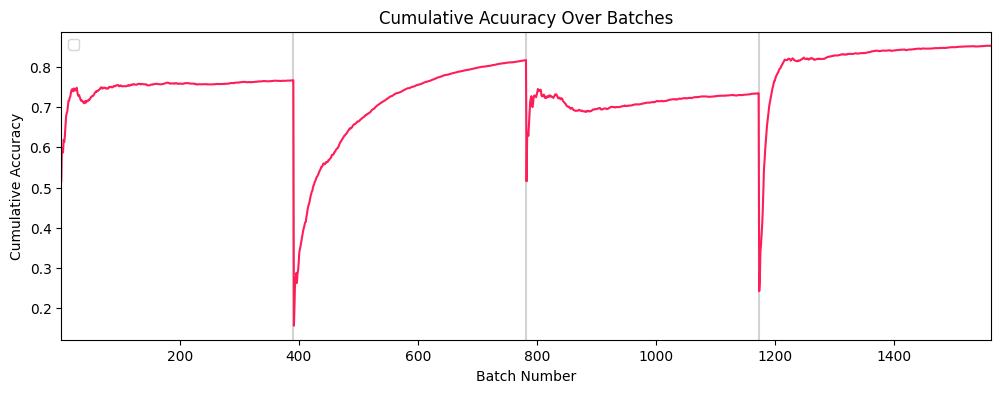

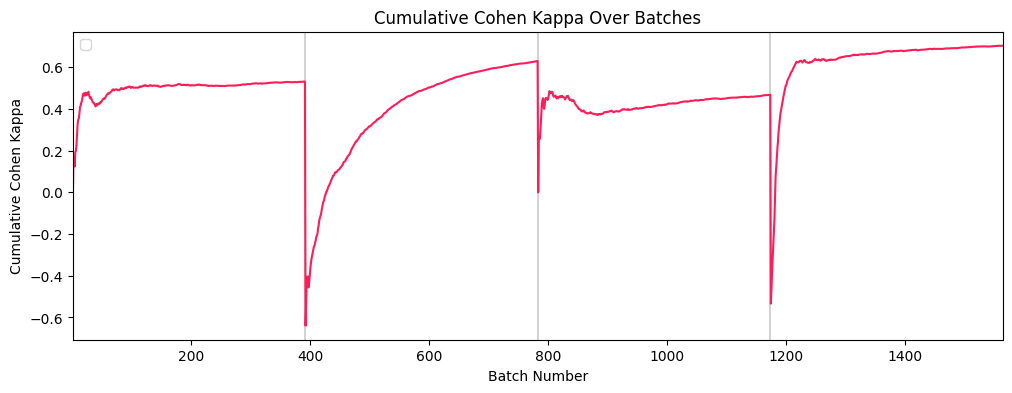

In [35]:
batch_size = 128
hidden_size = 50
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
pretrain_model_addr='performance/gru/gru-hidden50-kaiming_normal.pickle'
base_model='gru'
mask_init_fn=mask_init
mask_selection_NofBatch = 50
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,hidden_size=hidden_size, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init_fn=mask_init,base_model=base_model, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [ ]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-2341-t1_hidden250.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-2341-t1_hidden250.csv', index=False)

hidden_size 250
list of accuracies that used for evaluating and selecting the models =  [0.74265625]
list of kappa values that used for evaluating and selecting the models =  [0.49719329]
index of selcted mask for this task 0
All batches Accuracy=  0.8453604539641943
All batches cohen kappa=  0.6902844585535471
list of accuracies that used for evaluating and selecting the models =  [0.77953125 0.87984375]
list of kappa values that used for evaluating and selecting the models =  [0.55803848 0.7533463 ]
index of selcted mask for this task 1
All batches Accuracy=  0.8712515984654732
All batches cohen kappa=  0.7400055166019504
list of accuracies that used for evaluating and selecting the models =  [0.67921875 0.90609375 0.90328125]
list of kappa values that used for evaluating and selecting the models =  [0.3675017  0.80513177 0.80114265]
index of selcted mask for this task 1
All batches Accuracy=  0.8648497442455243
All batches cohen kappa=  0.7268939261774883
list of accuracies that use

All batches Accuracy=  0.8780850383631714
All batches cohen kappa=  0.7526850557464468


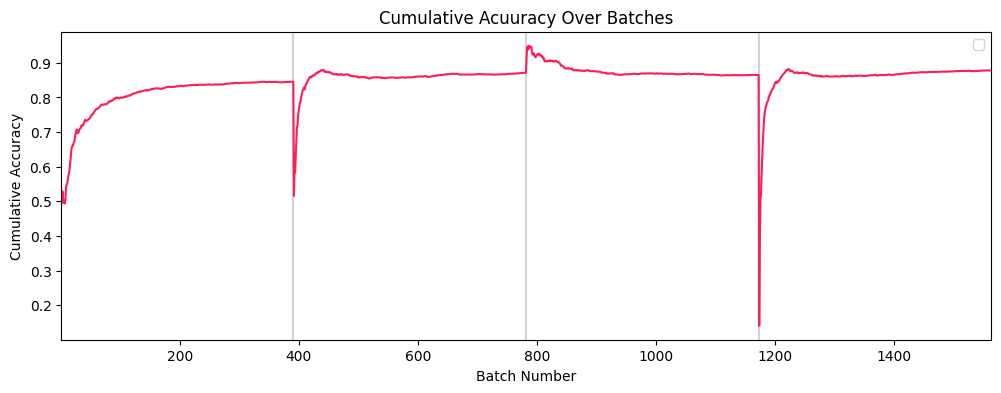

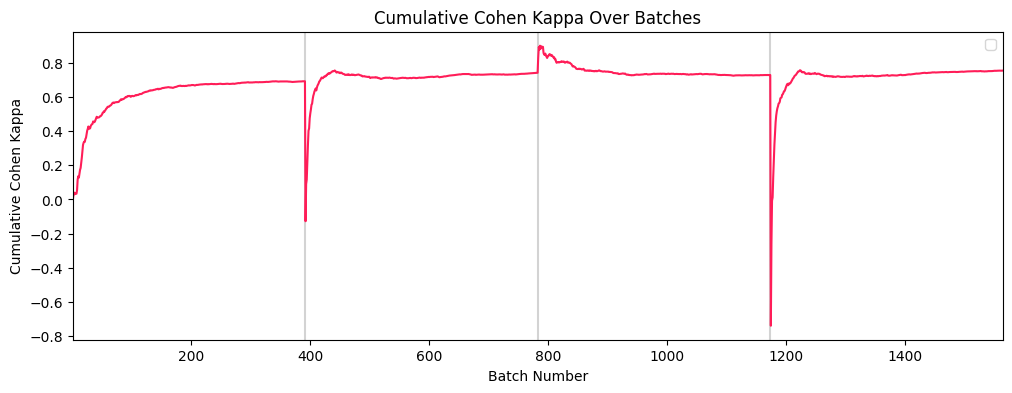

In [ ]:
batch_size = 128
hidden_size = 250
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_2_hiiden250.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,hidden_size=hidden_size, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [ ]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-2341-t2_hidden250.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-2341-t2_hidden250.csv', index=False)

hidden_size 250
list of accuracies that used for evaluating and selecting the models =  [0.72734375]
list of kappa values that used for evaluating and selecting the models =  [0.45547711]
index of selcted mask for this task 0
All batches Accuracy=  0.8051750319693095
All batches cohen kappa=  0.6084443497521531
list of accuracies that used for evaluating and selecting the models =  [0.7396875  0.83984375]
list of kappa values that used for evaluating and selecting the models =  [0.48803689 0.66653286]
index of selcted mask for this task 1
All batches Accuracy=  0.8707281010230179
All batches cohen kappa=  0.7380282156683905
list of accuracies that used for evaluating and selecting the models =  [0.70484375 0.88984375 0.88640625]
list of kappa values that used for evaluating and selecting the models =  [0.40509246 0.77037102 0.76832641]
index of selcted mask for this task 1
All batches Accuracy=  0.8638826726342711
All batches cohen kappa=  0.7247409812362907
list of accuracies that use

All batches Accuracy=  0.9024416560102302
All batches cohen kappa=  0.8009238496155995


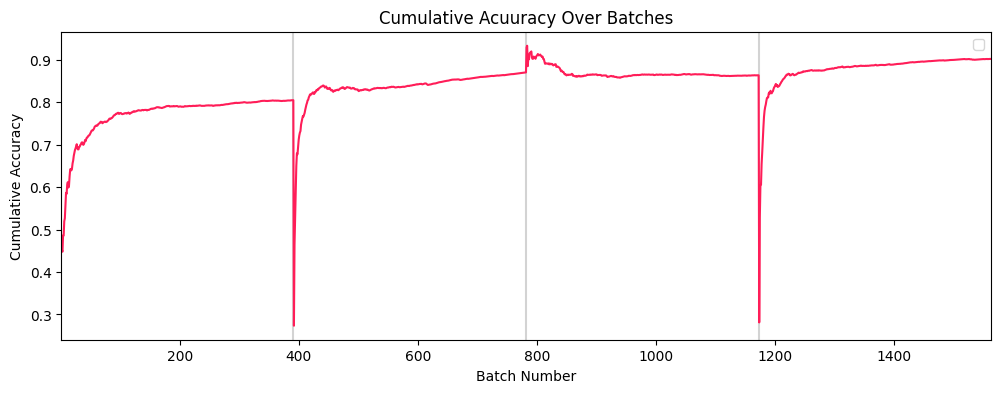

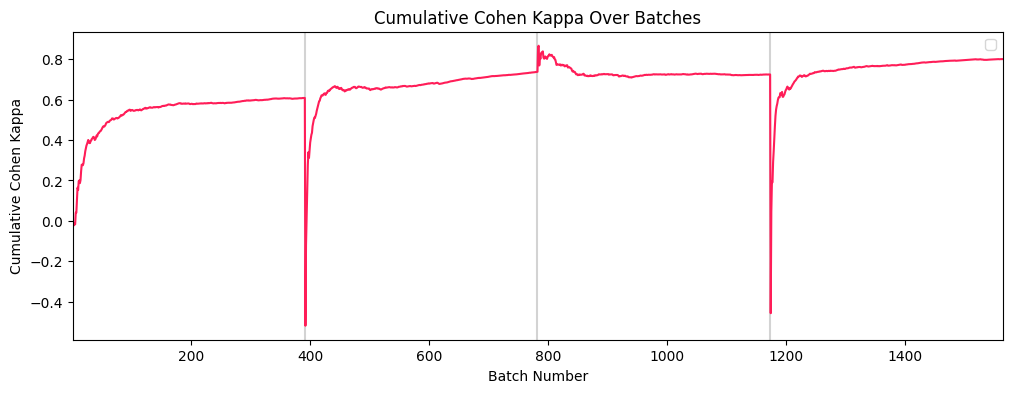

In [ ]:
batch_size = 128
hidden_size = 250
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_3_hiiden250.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,hidden_size=hidden_size, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [ ]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-2341-t3_hidden250.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-2341-t3_hidden250.csv', index=False)

hidden_size 250
list of accuracies that used for evaluating and selecting the models =  [0.6034375]
list of kappa values that used for evaluating and selecting the models =  [0.22916635]
index of selcted mask for this task 0
All batches Accuracy=  0.7900695332480818
All batches cohen kappa=  0.5819047653649831
list of accuracies that used for evaluating and selecting the models =  [0.7878125 0.8990625]
list of kappa values that used for evaluating and selecting the models =  [0.57792678 0.79139743]
index of selcted mask for this task 1
All batches Accuracy=  0.9088594948849105
All batches cohen kappa=  0.8155674299468165
list of accuracies that used for evaluating and selecting the models =  [0.74953125 0.91796875 0.90046875]
list of kappa values that used for evaluating and selecting the models =  [0.50131748 0.82869763 0.79762093]
index of selcted mask for this task 1
All batches Accuracy=  0.8905530690537085
All batches cohen kappa=  0.7786881387462397
list of accuracies that used f

All batches Accuracy=  0.9071411445012787
All batches cohen kappa=  0.8107530673217895


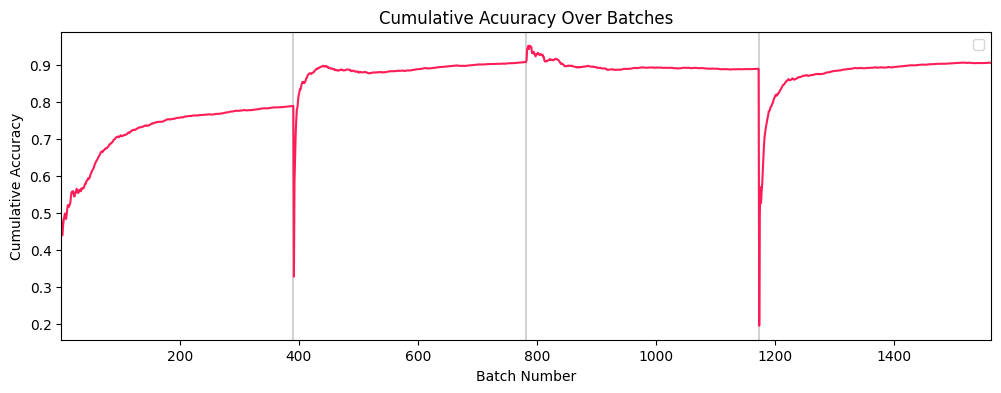

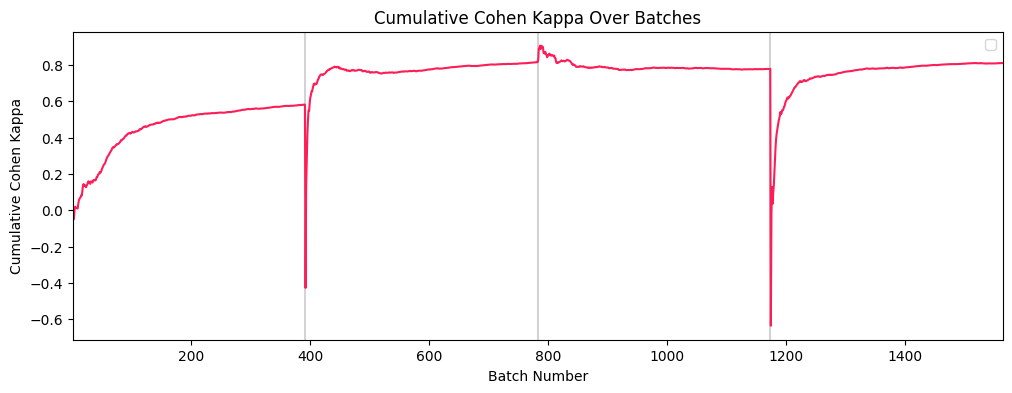

In [ ]:
batch_size = 128
hidden_size = 250
seq_len = 10
epoch_size=5
lr = 0.01
number_of_tasks=4
mask_selection_NofBatch = 50
mask_init='uniform'
dataset = "sine_rw10_mode5_extended_16-16_2341"
df = pd.read_csv(os.path.join("datasets/datasets", f"{dataset}.csv"))
pretrain_model_addr='performance/pretrain/pretrain_mode_gru_sine_rw10_mode5_extended_6-6_1234_4_hiiden250.pickle'
mask_weights=[]

model=cPB(model_class=PiggyBackGRU, lr = lr ,hidden_size=hidden_size, seq_len=seq_len, pretrain_model_addr=pretrain_model_addr,
           mask_weights=mask_weights, mask_init=mask_init, number_of_tasks=number_of_tasks,epoch_size=epoch_size)
iteration=1
# first loop for the iterations, for now it is just 1 iteration.
for iter in range(0,iteration):
  # loop for each task
  for task in range(1, df["task"].max() + 1):
    df_task = df[df["task"] == task]
    df_task = df_task.drop(columns="task")
    # loop based on each batch of data
    batch_cont=0
    model.weights_copy(task)
    for i in range(0, len(df_task), batch_size):
      x = df_task.iloc[i : i + batch_size, 0:-1].values.astype(np.float32)
      y = list(df_task.iloc[i : i + batch_size, -1])
      if batch_cont<mask_selection_NofBatch:
        for mask_index in range (0, task):
          model.predict_many(x,y,mask_index)
          model.learn_many(x,y,mask_index)
        batch_cont+=1
      elif batch_cont==mask_selection_NofBatch:
        best_mask_index=model.add_new_column()
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
        batch_cont+=1
      elif batch_cont>mask_selection_NofBatch:
        batch_cont+=1
        model.predict_many(x,y,best_mask_index)
        model.learn_many(x,y,best_mask_index)
    model.save_final_metrics(task,best_mask_index)
    model.final_weights_saving()
  model.plotting()


In [ ]:
pd.DataFrame(model.all_batch_acc).to_csv('results/acc-CPB-16_16-2341-t4.csv', index=False)
pd.DataFrame(model.all_batch_kappa).to_csv('results/kappa-CPB-16_16-2341-t4.csv', index=False)

In [ ]:
df1 = np.array(pd.read_csv('results/kappa-16_16-1234-4.csv'))
df2 = np.array(pd.read_csv('results/kappa-16_16-1432-4.csv'))
df3 = np.array(pd.read_csv('results/kappa-16_16-2143-4.csv'))
df4 = np.array(pd.read_csv('results/kappa-16_16-2341-4.csv'))
all_x=np.concatenate((df1,df2,df3,df4),axis=0)
y = np.cumsum(all_x, axis=1) / np.arange(1, all_x.shape[1] + 1)
vertical_lines_x = [all_x.shape[1], 2*all_x.shape[1], 3*all_x.shape[1]]
x = list(range(1,4*all_x.shape[1] + 1))
fig, ax = plt.subplots(figsize=(12, 4))
ax.margins(x=0.0)
label_list=['16_16-1234','16_16-1432','16_16-2143','16_16-2341']

for i in vertical_lines_x:
  plt.axvline(x=i, color='#D3D3D3', linestyle='-')

for i in range(0,y.shape[0],4):
  ax.plot(x, np.concatenate((y[i],y[i+1],y[i+2],y[i+3]),axis=0), label= label_list[int(i/4)])
plt.xlabel('Batch Number')
plt.ylabel('Cumulative Cohen Kappa')
plt.title('Cumulative Cohen Kappa Over Batches')
plt.legend()
plt.show()